# 二进制小数的表示

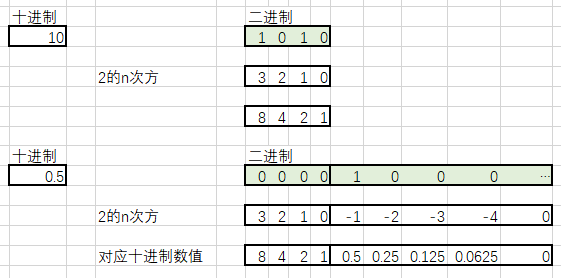

# 二进制小数的存储

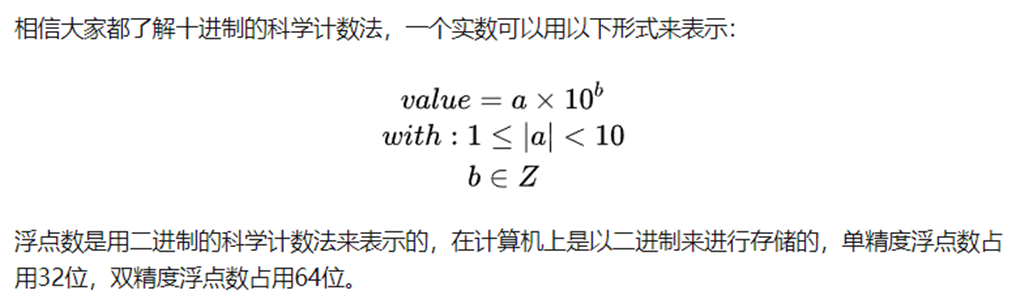

# 浮点数标准（IEEE754）
- Reference1 - IEEE754：https://standards.ieee.org/ieee/754/993/
- Reference2 - 知乎回答：https://zhuanlan.zhihu.com/p/28162086
- Reference3 - 知乎回答：https://zhuanlan.zhihu.com/p/58731780
- Reference4 - 在线二进制计算器：https://www.binaryconvert.com/result_double.html?

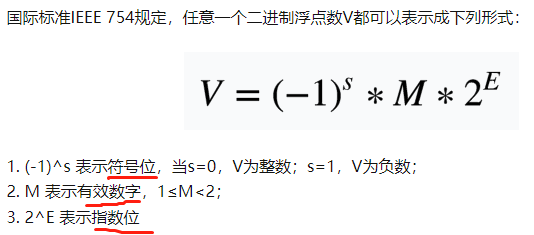

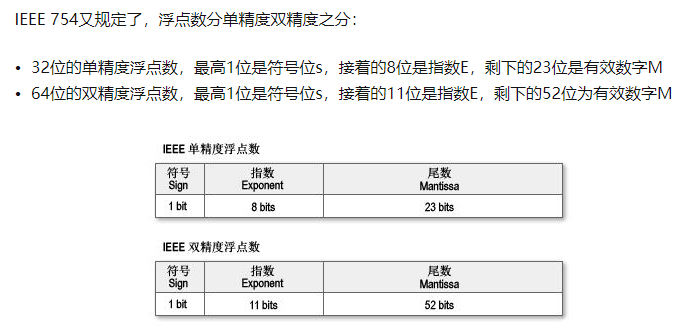

- 32位浮点数
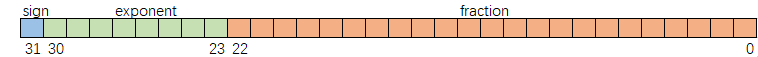

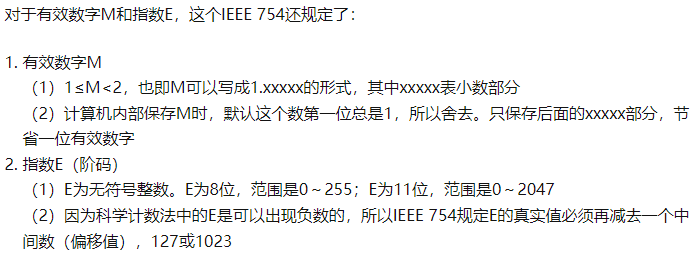

In [233]:
""" 32位浮点数能表示的10进制数有效位数是7~8位 """
print(2**-(23+1))

5.960464477539063e-08


In [234]:
""" 64位浮点数能表示的10进制数有效位数是15~16位 """ 
print( 2**-(52+1) )

1.1102230246251565e-16


# 十进制浮点数转二进制

## eg：0.875

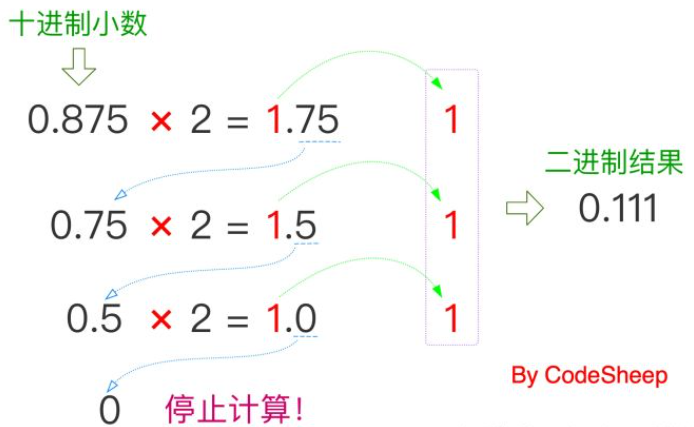

- 符号位 * 有效数字 * 指数位：(-1)^0 * 1.11 * 2^-1
- E的存储： 先加127，等于126；长度为8 -> 二进制为：0111 1110
- M的存储： 默认第一位为1无需存储，剩余长度为23，尾数补齐 -> 二进制为：1100000000000000000000000

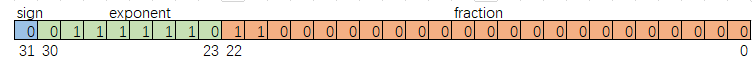

## 0.875用程序转换为二进制表示

In [349]:
def dTob(n, f_type='float'):
    '''
        把一个十进制数n，转换成二进制
            Input:
                n:     十进制小数
                f_type:小数类型（float，或double）
            Out_put：
                (sign, E_level, M, str_num_2)
                符号位 指数位阶数  有效数字  二进制存储（字符串格式）
    '''
    # 计算符号位（sign）
    sign = 1 if n<0 else 0
    
    # 根据f_type确定各位数
    if f_type=='float':
        exp_digit, exp_shift, valid_num_digit = (8, 127, 23) 
    elif f_type=='double':
        exp_digit, exp_shift, valid_num_digit = (11, 1023, 52) 
    
    # 对输入n的整数和小数顺序进行二进制转换,以确定output
    str_num = '{:.15f}'.format(n)
    str_int, str_decimal = str_num.split('.') # 分离整数部分和小数部分
    
    # 1. 整数部分，二进制转换
    integer = int(str_int)
    str_int_2 = '{:b}'.format(integer)  #整数部分转换成二进制 
    int_valid_cnt = 0 if str_int_2[0]=='0' else len(str_int_2) # 可能已经 >valid_num_digit+1，后边拼接时要记得截断
    
    # 2.小数部分，二进制转换
    str_decimal_2 = ''
    decimal_valid_cnt = 0
    decimal = n - integer
    while (decimal_valid_cnt+int_valid_cnt) < (valid_num_digit+1): # 总有效位数没有达到需求
        decimal *= 2
        if decimal > 1 :   # 若乘以2后为大于1的小数，则要减去整数部分
            decimal_valid_cnt += 1
            decimal -= 1
            str_decimal_2 += '1'
        elif decimal < 1:  # 乘以2后若仍为小于1的小数，则继续使用这个数乘2变换进制
            if int_valid_cnt+decimal_valid_cnt>0: # 若此时有效位计数已经大于0，则继续计数，否则不计数
                decimal_valid_cnt += 1
            str_decimal_2 += '0'
        else:    #当乘以2后正好为1，则进制变换提前停止，补足str_decimal_2到需要长度
            str_decimal_2 += ('1' + '0'*(valid_num_digit-int_valid_cnt-decimal_valid_cnt))
            decimal_valid_cnt = (valid_num_digit+1-int_valid_cnt)            
            break
    
    # 3.拼接 二进制整数和小数 部分, 得到 M 和 E_level
    if int_valid_cnt>=(valid_num_digit+1): # 整数部分已经超过了有效位数
        M_nodot = str_int_2[:valid_num_digit+1]
    elif '1' in str_int_2:  # 整数部分没有超过有效位数 & 有效数字从整数开始
        E_level = len(str_int_2)-1
        M_nodot = (str_int_2 + str_decimal_2)[: valid_num_digit+1]
    else: # 整数部分没有超过有效位数 & 有效数字从小数开始
        idx_begin = str_decimal_2.find('1')
        E_level = - idx_begin - 1
        M_nodot = str_decimal_2[idx_begin: idx_begin+valid_num_digit+1]
    M = '{}.{}'.format(M_nodot[0], M_nodot[1:])
    
    # 4. E_level做转换，得到 E_level_shift_2
    E_level_shift = E_level + exp_shift
    E_level_shift_2 = '{:b}'.format(E_level_shift).zfill(exp_digit)
    
    # 5. 拼接得到 str_num_2
    str_num_2 = '{} | {} | {}'.format(sign, E_level_shift_2, M_nodot[1:])
    return (sign, E_level, M, str_num_2)

In [350]:
res = dTob(0.875, 'float')
print(len(res[2]))
res

25


(0, -1, '1.11000000000000000000000', '0 | 01111110 | 11000000000000000000000')

In [351]:
res = dTob(0.875, 'double')
print(len(res[2]))
res

54


(0,
 -1,
 '1.1100000000000000000000000000000000000000000000000000',
 '0 | 01111111110 | 1100000000000000000000000000000000000000000000000000')

## 从二进制表示转回十进制表示

In [284]:
def bTod(S, M, E_level, f_type='float'):
    '''
        把一个二进制浮点数n转换成十进制
            Input:
                M:       有效数字
                E_level: 指数位阶数
            Output：
                num：    十进制下的数字
    '''
    # 根据f_type确定相关部分的位数
    if f_type=='float':
        exp_digit, exp_shift, valid_num_digit, valid_cnt = (8, 127, 23, 8)
    elif f_type=='double':
        exp_digit, exp_shift, valid_num_digit, valid_cnt = (11, 1023, 52, 16)    
    
    num = 0.0
    for i,m in enumerate(M.replace('.', '')):
        num += 2**(E_level-i) * int(m)
    # 确定正负
    num *= (-1)**S    
    return num


In [288]:
bTod(S=0, M='1.11000000000000000000000', E_level=-1, f_type='float')

0.875

In [289]:
bTod(S=0, M='1.1100000000000000000000000000000000000000000000000000', E_level=-1, f_type='float')

0.875

# 二进制相加

In [240]:
def add_binary_nums(x, y):  
    """ 两个二进制相加的二进制结果 """
    max_len = max(len(x), len(y))  

    x = x.zfill(max_len)  
    y = y.zfill(max_len)  

    result = ''  
    carry = 0  

    for i in range(max_len-1, -1, -1):  
        r = carry  
        r += 1 if x[i] == '1' else 0  
        r += 1 if y[i] == '1' else 0  
        result = ('1' if r % 2 == 1 else '0') + result  
        carry = 0 if r < 2 else 1         

    if carry !=0 : 
        result = '1' + result  

    return result.zfill(max_len) 

In [369]:
print(add_binary_nums('0', '1'))
print(add_binary_nums('1', '1'))
print(add_binary_nums('111', '1'))

1
10
1000


# 浮点数计算 - 0.1+0.2==0.3？

In [370]:
print(0.1 + 0.1 == 0.2)
print(0.1 + 0.2 == 0.3)

True
False


## 浮点数计算方法
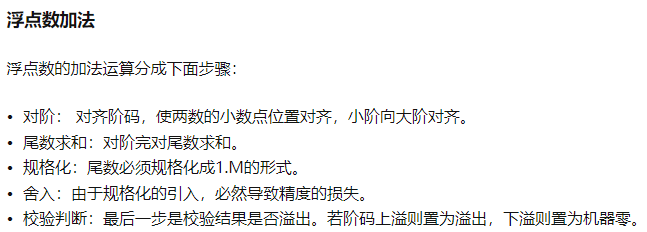

In [371]:
# 0.1的二进制储存结果
res = dTob(0.1, 'double')
res

(0,
 -4,
 '1.1001100110011001100110011001100110011001100110011010',
 '0 | 01111111011 | 1001100110011001100110011001100110011001100110011010')

In [372]:
# 0.2的二进制储存结果
res = dTob(0.2, 'double')
res

(0,
 -3,
 '1.1001100110011001100110011001100110011001100110011010',
 '0 | 01111111100 | 1001100110011001100110011001100110011001100110011010')

### 十进制转二进制后结果
- 0.1 -> 0 | 01111111011 | (1)1001100110011001100110011001100110011001100110011010
- 0.2 -> 0 | 01111111100 | (1)1001100110011001100110011001100110011001100110011010

#### 二进制相加（0.1+0.1）
- 0.1 -> 0 | 01111111100 | (1)1001100110011001100110011001100110011001100110011010
- 0.1 -> 0 | 01111111100 | (1)1001100110011001100110011001100110011001100110011010

In [373]:
bin_res = add_binary_nums('11001100110011001100110011001100110011001100110011010', # 0.1
                          '11001100110011001100110011001100110011001100110011010') # 0.1
print(len(bin_res))
bin_res

54


'110011001100110011001100110011001100110011001100110100'

In [290]:
bTod(0, '1.1001100110011001100110011001100110011001100110011010', -3, 'double')

0.2

#### 二进制相加（0.1+0.2）
- 0.1 -> 0 | 01111111011 | (1)1001100110011001100110011001100110011001100110011010 
- 0.2 -> 0 | 01111111100 | (1)1001100110011001100110011001100110011001100110011010

- 0.1 -> 0.00011001100110011001100110011001100110011001100110011010
- 0.2 -> 0.0011001100110011001100110011001100110011001100110011010

In [292]:
bin_res = add_binary_nums('01100110011001100110011001100110011001100110011001101',  # 0.1对阶后
                          '11001100110011001100110011001100110011001100110011010')  # 0.2
print(len(bin_res))
bin_res

54


'100110011001100110011001100110011001100110011001100111'

- length = 54: 100110011001100110011001100110011001100110011001100111
- length = 53: 10011001100110011001100110011001100110011001100110100

In [293]:
bTod(0, '1.0011001100110011001100110011001100110011001100110100', -2, 'double')

0.30000000000000004

In [294]:
0.1 + 0.2

0.30000000000000004

# 浮点数计算 - 有效位数边缘试探

In [199]:
import numpy as np

## Float32

### 一个精度边缘的例子

In [379]:
a1 = np.float32(4.0) 
a2 = np.float32(5.0)

b1 = np.float32(1e+7)
b2 = np.float32(1e+8)

In [380]:
print('4 + 1e+7 - 1e+7 = ', a1 + b1 - b1)  
print('5 + 1e+7 - 1e+7 = ', a2 + b1 - b1)  

print('4 + 1e+8 - 1e+8 = ', a1 + b2 - b2)  
print('5 + 1e+8 - 1e+8 = ', a2 + b2 - b2) 

4 + 1e+7 - 1e+7 =  4.0
5 + 1e+7 - 1e+7 =  5.0
4 + 1e+8 - 1e+8 =  0.0
5 + 1e+8 - 1e+8 =  8.0


## Double

### 重新跑Float32的例子

In [381]:
a1 = np.float64(4.0) 
a2 = np.float64(5.0)

b1 = np.float64(1e+7)
b2 = np.float64(1e+8)

In [382]:
print('4 + 1e+7 - 1e+7 = ', a1 + b1 - b1)  
print('5 + 1e+7 - 1e+7 = ', a2 + b1 - b1)  

print('4 + 1e+8 - 1e+8 = ', a1 + b2 - b2)  
print('5 + 1e+8 - 1e+8 = ', a2 + b2 - b2) 

4 + 1e+7 - 1e+7 =  4.0
5 + 1e+7 - 1e+7 =  5.0
4 + 1e+8 - 1e+8 =  4.0
5 + 1e+8 - 1e+8 =  5.0


### Double下的例子

In [383]:
a1 = np.float64(4.0) 
a2 = np.float64(5.0)

b1 = np.float64(1e+15)
b2 = np.float64(1e+16)

In [384]:
a1 = 4.0 
a2 = 5.0

b1 = 1e+15
b2 = 1e+16

In [386]:
print('4 + 1e+15 - 1e+15 = ', a1 + b1 - b1)  
print('5 + 1e+15 - 1e+15 = ', a2 + b1 - b1)  

print('4 + 1e+16 - 1e+16 = ', a1 + b2 - b2)  
print('5 + 1e+16 - 1e+16 = ', a2 + b2 - b2) 

4 + 1e+15 - 1e+15 =  4.0
5 + 1e+15 - 1e+15 =  5.0
4 + 1e+16 - 1e+16 =  4.0
5 + 1e+16 - 1e+16 =  4.0
